# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The task of identifying key drivers for used car prices can be reframed as a supervised machine learning problem, specifically a regression task, where the goal is to develop a predictive model that estimates the price of a used car based on a variety of features. These features include make, model, mileage, year, condition, fuel type, transmission, location, and other relevant attributes that influence the value of a vehicle.

The first step in this process is exploratory data analysis (EDA), where we will assess the dataset for patterns, relationships, and potential issues such as missing values, outliers, and multicollinearity among features. This will help us determine which variables have the most significant impact on car prices. Feature selection and engineering will be crucial in improving model accuracy, as certain categorical variables may need encoding, numerical variables may require transformations, and new derived features may enhance predictive power.

Once the data is preprocessed, we will apply various regression modeling techniques, including linear regression, tree-based models (such as Random Forest, Gradient Boosting and XGBoost), and ensemble methods to predict the target variable, which is the car’s price. The models will be trained and evaluated using cross-validation to ensure robustness and avoid overfitting. Performance metrics such as Root Mean Squared Error (RMSE), Mean Squared Error (MSE), and R-squared will be used to assess the accuracy and effectiveness of each model.

Beyond just predictive modeling, our goal is to extract actionable business insights for the used car dealership. By analyzing feature importance, we can determine which factors have the greatest impact on pricing and guide the dealership on optimal purchasing and pricing strategies. For instance, understanding the effect of mileage, vehicle age, and brand reputation on price depreciation can help in inventory selection and marketing efforts. Additionally, location-based trends may reveal regional pricing differences that can be leveraged for competitive advantage.

The final deliverables will include a well-performing model, report summarizing key insights, and specific recommendations to help the dealership optimize pricing strategies, maximize profitability, and better understand consumer preferences in the used car market.

In [148]:
# Importing libraries

import pandas as pd
import numpy as np

import re 
from scipy import stats
from scipy.stats import skew, randint, uniform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
import statsmodels.stats.api as sms

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score #, make_scorer
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
# from sklearn.svm import SVR
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [149]:
# Classes and Functions Used

# Custom Transformer: Frequency Encoding

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Custom transformer for frequency encoding.
    
    Each category is replaced with the frequency of its occurrence in the dataset.
    """
    def __init__(self):
        self.freq_maps = {}

    def fit(self, X, y = None):
        """Compute the frequency of each category."""
        for col in X.columns:
            self.freq_maps[col] = X[col].value_counts()
        return self

    def transform(self, X):
        """Apply frequency encoding to transform categorical variables."""
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.freq_maps[col]).fillna(0)  # Handle unseen categories with 0
        return X_transformed


# Custom Transformer: Ordinal Encoding

class OrdinalEncoder(BaseEstimator, TransformerMixin):
    """
    Custom transformer for ordinal encoding based on a predefined mapping.
    """
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y = None):
        """No fitting required as mapping is predefined."""
        return self

    def transform(self, X):
        """Apply ordinal encoding by replacing values based on the mapping."""
        return X.replace(self.mapping)


# Extracting first word

def extract_first_word(text: str) -> str:
    """
    Extracts the first word from a given string after removing non-alphanumeric characters.

    Parameters:
    text (str): The input string from which the first word needs to be extracted.

    Returns:
    str: The first word of the cleaned string. Returns an empty string if no word is found.
    """
    # Ensure the input is a string and remove non-alphanumeric characters except spaces

    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    
    # Split the cleaned string by spaces and return the first word (if available)

    first_word = cleaned_text.split()[0] if cleaned_text.strip() else ''
    
    return first_word


# Defining a function to remove outliers

def remove_outliers(data, column, multiplier = 1.5):
    '''
    input: data with outliers - pandas dataframe
    output: outlier removed data - pandas dataframe

    This function removes outliers from the data using the IQR method

    '''

    # Calculate 25th percentile and 75th percentile

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)

    # Calculate IQR

    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    # lower multiplier means more sensitive, identifies more points as outliers

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Remove outliers

    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return data

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Steps for Data Understanding
To effectively analyze and model the used car price dataset, it is essential to first understand its structure, contents, and potential quality issues. Below are the key steps to achieve this:

1. Load and Inspect the Data: 
Read the dataset into a Pandas DataFrame, check the dataset dimensions to understand the number of records and features.
Inspect the column names and data types to determine categorical vs. numerical variables.

2. Assess Missing Values, negative values and Duplicates: 
Check for missing values, negative values on numerical columns, identify duplicate entries to avoid redundant data and generate summary statistics of the dataset. Decide on appropriate handling techniques for missing or duplicate data.

3. Detect and Handle Outliers: 
Use box plots to visually detect outliers in key numeric features like mileage and price and apply statistical methods (e.g., Z-score, IQR method) to quantify and address extreme values.

4. Distribution and skewness of features: 
Check the distribution and skewness of numerical features and apply appropriate transformations if needed.

5. Feature Relationships and Correlations: 
Check correlations between numerical variables using a heatmap (this helps in identifying multicollinearity). Analyze category-wise trends using bar plots (e.g., average price by brand, transmission type, or fuel type).

6. Assess Data Completeness and Consistency: 
Ensure uniform formatting of categorical variables (e.g., "sedan" vs. "Sedan"). Verify if date-based fields (e.g., model year) are in the correct format and range. Identify inconsistencies in unit measures (e.g., mileage recorded in different units).

7. Identify Potential Feature Engineering Opportunities: 
Create new features if applicable, convert categorical variables into numerical encodings for modeling and aggregate features (e.g., binning mileage into categories: low, medium, high) if applicable.

By conducting these steps, we can ensure the dataset is clean, structured, and ready for further modeling while also gaining key insights into the factors that influence used car prices.

In [150]:
# Reading data from csv file

data = pd.read_csv('data/vehicles.csv')

# Checking the first five rows of a dataset

data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [151]:
# Checking the shape of the dataset

data.shape

(426880, 18)

In [152]:
# Checking dataset information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [153]:
# Checking null values in the dataset

pd.DataFrame(np.round(data.isnull().mean() * 100, 2), columns = ['% missing values']).astype(str) + ' %'

,% missing values
id,0.0 %
region,0.0 %
price,0.0 %
year,0.28 %
manufacturer,4.13 %
model,1.24 %
condition,40.79 %
cylinders,41.62 %
fuel,0.71 %
odometer,1.03 %


In [154]:
# Checking duplicate values in the dataset

data[data.duplicated()]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state


In [155]:
# Summary statistics of the dataset, including all data types

data.describe(include = 'all')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
count,4.268800e+05,426880,4.268800e+05,425675.000000,409234,421603,252776,249202,423867,4.224800e+05,418638,424324,265838,296313,120519,334022,296677,426880
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614
mean,7.311487e+09,NaN,7.519903e+04,2011.235191,NaN,NaN,NaN,NaN,NaN,9.804333e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.473170e+06,NaN,1.218228e+07,9.452120,NaN,NaN,NaN,NaN,NaN,2.138815e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.207408e+09,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.308143e+09,NaN,5.900000e+03,2008.000000,NaN,NaN,NaN,NaN,NaN,3.770400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.312621e+09,NaN,1.395000e+04,2013.000000,NaN,NaN,NaN,NaN,NaN,8.554800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.315254e+09,NaN,2.648575e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,1.335425e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can also see that the minimum value for price and odometer of a car is 0 dollars which does not make sense. For numerical columns a high standard deviation suggests that the data points are widely spread from the mean, tt can be an indicator of potential outliers since the spread is unusually large.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [156]:
# Filtering records from dataset that has >= 0 price and odometer

data = data[(data.price > 0) & (data.odometer > 0)]

# filling missing values with 'unknown' for cateogrical columns

categories = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color' ]
for column in categories:
    data[column] = data[column].fillna('unknown')

# We also observed that the model is a a text field, we will extract only the first word from the model name column of the dataset.

data['model'] = data['model'].apply(extract_first_word)

# dropping non - relevant columns

data.drop(columns = ['id', 'VIN'], inplace = True)

# dropping missing values/NaN from the dataset

clean_data = data.dropna()

clean_data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra,good,8 cylinders,gas,57923.0,clean,other,unknown,unknown,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado,good,8 cylinders,gas,71229.0,clean,other,unknown,unknown,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado,good,8 cylinders,gas,19160.0,clean,other,unknown,unknown,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra,good,8 cylinders,gas,41124.0,clean,other,unknown,unknown,pickup,red,al
31,auburn,15000,2013.0,ford,f150,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al


Tree-based models are typically robust to outliers compared to other models such as linear regression, but extreme or numerous outliers could have a minor effect on the model's performance, particularly if the model is overfitted (such as with deep trees). Techniques like tree pruning or ensemble methods (like Random Forest and XGBoost) can help mitigate any minor effects of outliers. For linear regression purposes, we will check and remove outliers.

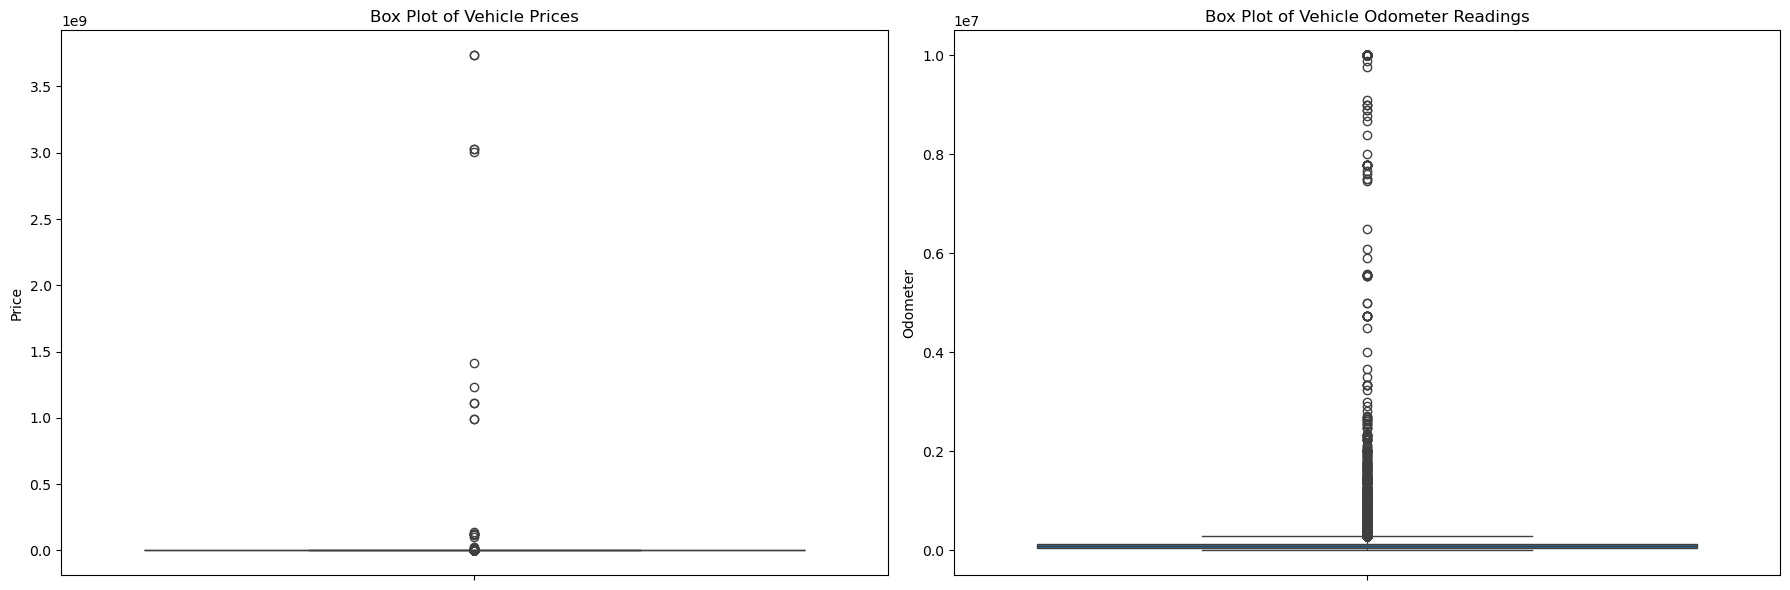

In [157]:
# Checking for outliers in odometer and price columns

plt.figure(figsize = (18, 6))

# Box plot for price

plt.subplot(1, 2, 1)
sns.boxplot(y = clean_data.price)
plt.title('Box Plot of Vehicle Prices')
plt.ylabel('Price')

# Box plot for odometer

plt.subplot(1, 2, 2)
sns.boxplot(y = clean_data.odometer)
plt.title('Box Plot of Vehicle Odometer Readings')
plt.ylabel('Odometer')

plt.tight_layout()
plt.show()

In [158]:
# We will remove the outliers by using the IQR method

# Removing outliers from the price column

overall_data_outlier_removed = remove_outliers(clean_data, 'price', 1.4)

# Removing outliers from the odometer column

overall_data_outlier_removed = remove_outliers(overall_data_outlier_removed, 'odometer', 1.4)

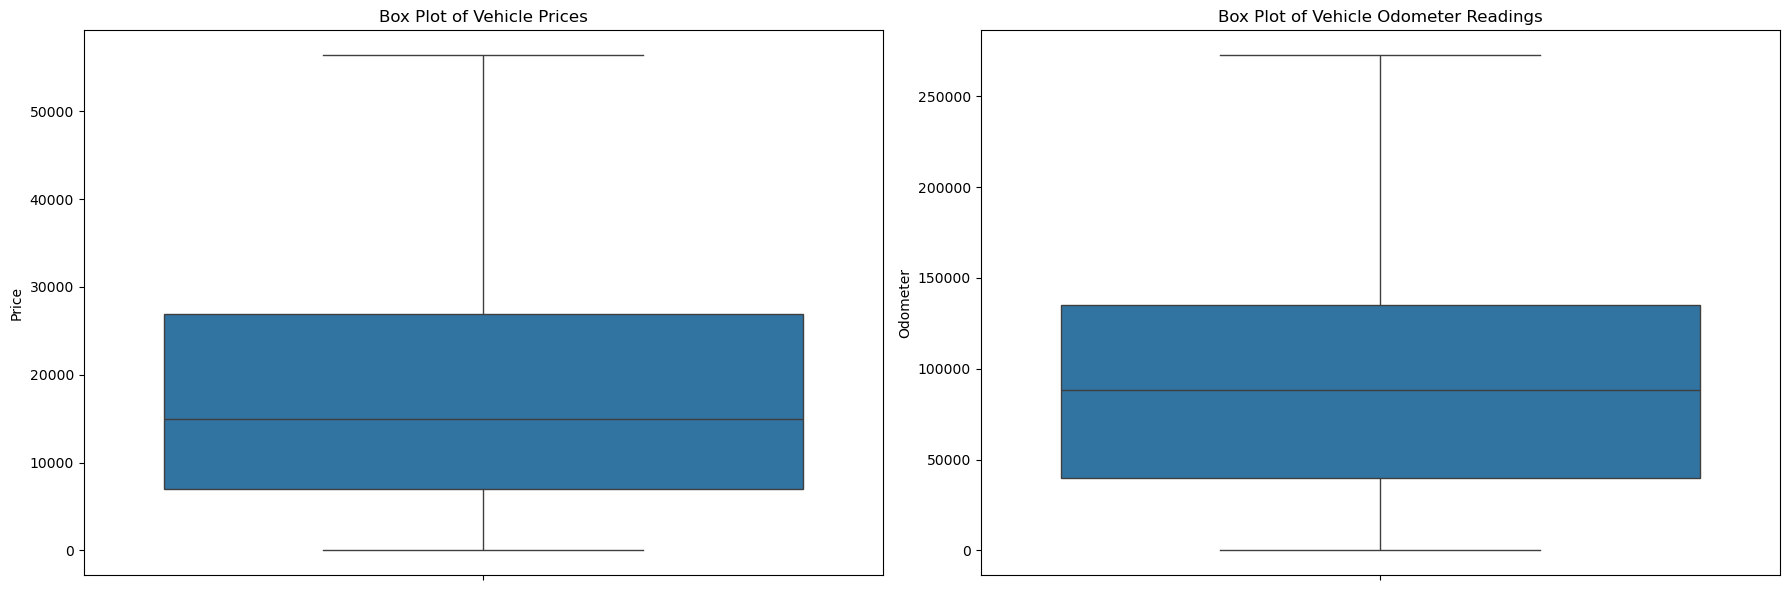

In [159]:
# Verifying that the outliers have been removed

plt.figure(figsize = (18, 6))

# Box plot for price

plt.subplot(1, 2, 1)
sns.boxplot(y = overall_data_outlier_removed.price)
plt.title('Box Plot of Vehicle Prices')
plt.ylabel('Price')

# Box plot for odometer

plt.subplot(1, 2, 2)
sns.boxplot(y = overall_data_outlier_removed.odometer)
plt.title('Box Plot of Vehicle Odometer Readings')
plt.ylabel('Odometer')

plt.tight_layout()
plt.show()

In [160]:
# From the box plot above, we can see that we have successfully removed the outliers from the dataset.
# We also see values are closer to zero. Lets check the minimum and maximum values for these two numerical features

print(f"Minimum price of a car in a dataset is", overall_data_outlier_removed.price.min())
print(f"Maximum price of a car in a dataset is", overall_data_outlier_removed.price.max())

print(f"Minimum odometer reading of a car in a dataset is", overall_data_outlier_removed.odometer.min())
print(f"Maximum odometer reading of a car in a dataset is", overall_data_outlier_removed.odometer.max())

Minimum price of a car in a dataset is 1
Maximum price of a car in a dataset is 56409
Minimum odometer reading of a car in a dataset is 1.0
Maximum odometer reading of a car in a dataset is 272641.0


In [161]:
# Removing top and bottom 5% of the dataset

overall_data_outlier_removed = overall_data_outlier_removed[
    (overall_data_outlier_removed.price < np.quantile(overall_data_outlier_removed.price, 0.95)) & 
    (overall_data_outlier_removed.odometer < np.quantile(overall_data_outlier_removed.odometer, 0.95))
]

overall_data_outlier_removed = overall_data_outlier_removed[
    (overall_data_outlier_removed.price > np.quantile(overall_data_outlier_removed.price, 0.05)) & 
    (overall_data_outlier_removed.odometer > np.quantile(overall_data_outlier_removed.odometer, 0.05))
]


In [162]:
# Checking the price and odometer value after filtering out the top and bottom 5% of the data

print(f"Minimum price of a car in a cleaned dataset is", overall_data_outlier_removed.price.min())
print(f"Maximum price of a car in a cleaned dataset is", overall_data_outlier_removed.price.max())


print(f"Minimum odometer reading of a car in a cleaned dataset is", overall_data_outlier_removed.odometer.min())
print(f"Maximum odometer reading of a car in a cleaned dataset is", overall_data_outlier_removed.odometer.max())

Minimum price of a car in a cleaned dataset is 1997
Maximum price of a car in a cleaned dataset is 40988
Minimum odometer reading of a car in a cleaned dataset is 8219.0
Maximum odometer reading of a car in a cleaned dataset is 199999.0


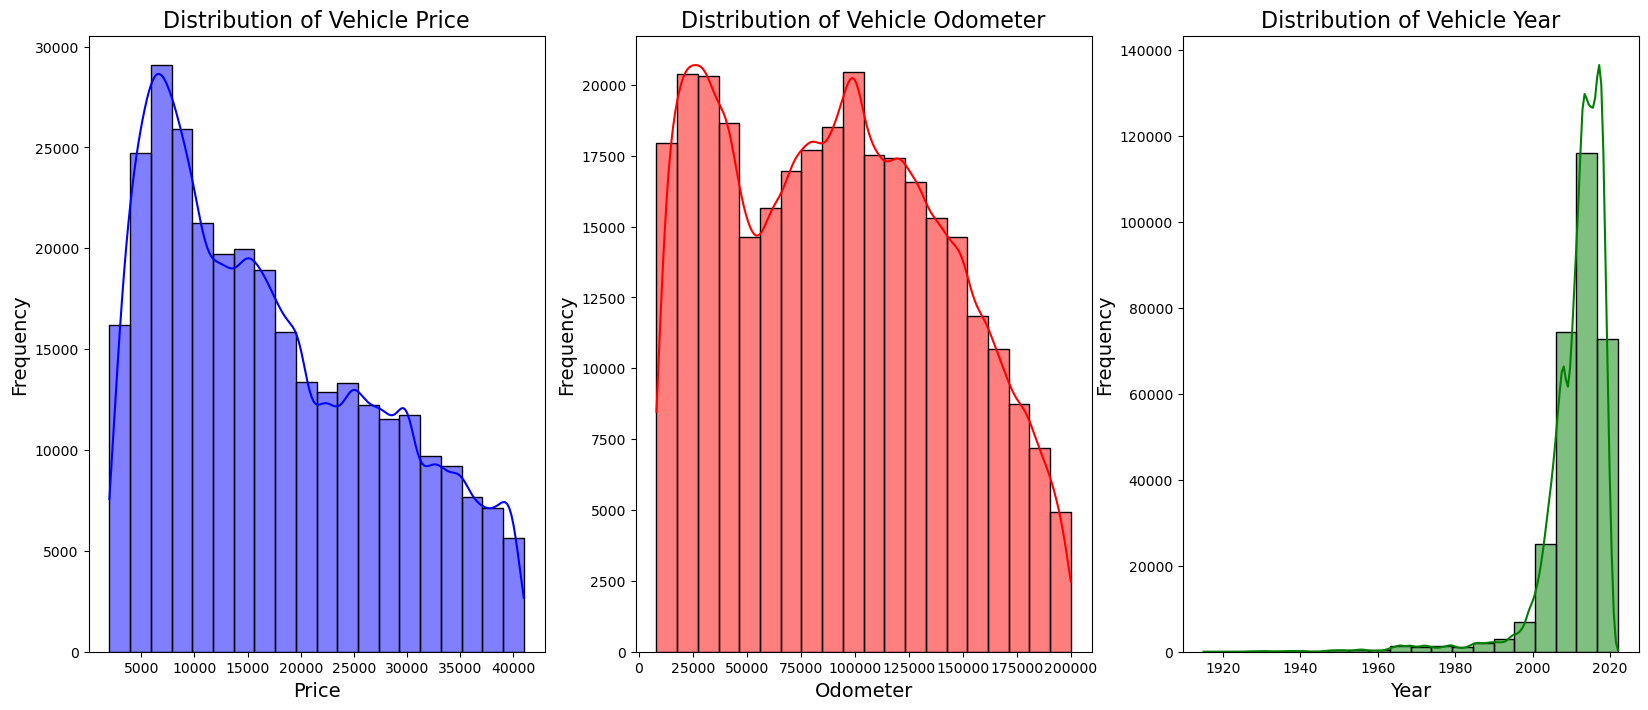

In [163]:
# plotting the distribution of the price, odometer and year columns

plt.figure(figsize = (20, 8))

plt.subplot(1, 3, 1)
sns.histplot(overall_data_outlier_removed.price, bins = 20, kde = True, color = 'blue')
plt.title('Distribution of Vehicle Price', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.subplot(1, 3, 2)
sns.histplot(overall_data_outlier_removed.odometer, bins = 20, kde = True, color = 'red')
plt.title('Distribution of Vehicle Odometer', fontsize = 16)
plt.xlabel('Odometer', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.subplot(1, 3, 3)
sns.histplot(overall_data_outlier_removed.year, bins = 20, kde = True, color = 'green')
plt.title('Distribution of Vehicle Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.show()
plt.close()

We can see that the price and odometer columns are right skewed and year values is left skewed. Now, we will check the skeweness values of the numerical columns


In [164]:

skewness = overall_data_outlier_removed[['price', 'odometer', 'year']].apply(lambda x: skew(x))
skewness

price       0.512934
odometer    0.169817
year       -3.513056
dtype: float64

We also observe that there is not much data before year 2000. We will remove the records that are below year 2000

In [165]:
overall_data_outlier_removed = overall_data_outlier_removed[overall_data_outlier_removed['year'] >= 2000]

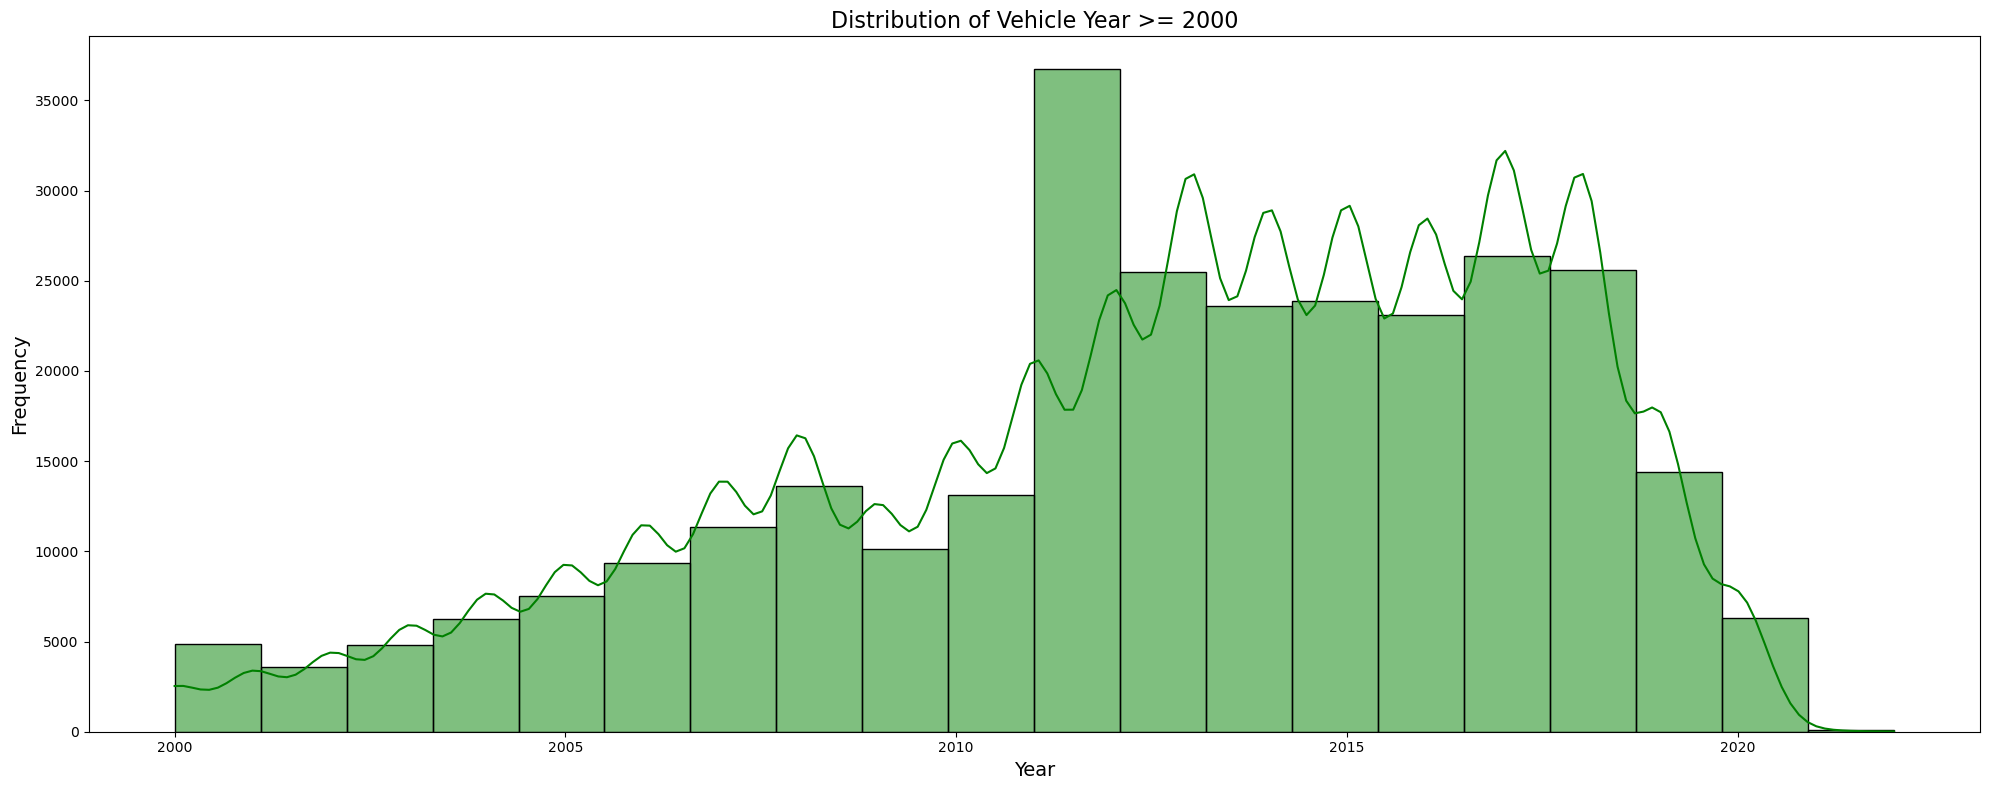

In [166]:
# Visualize the year distribution after removing year < 2000

plt.figure(figsize = (20, 8))

sns.histplot(overall_data_outlier_removed.year, bins = 20, kde = True, color = 'green')
plt.title('Distribution of Vehicle Year >= 2000', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

plt.tight_layout()
plt.show()
plt.close()

In [167]:
#  Check the skewness one more time after removing year < 2000

skewness = overall_data_outlier_removed[['price', 'odometer', 'year']].apply(lambda x: skew(x))
skewness

price       0.483579
odometer    0.172793
year       -0.615057
dtype: float64

In [168]:
overall_data_outlier_removed.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra,good,8 cylinders,gas,57923.0,clean,other,unknown,unknown,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado,good,8 cylinders,gas,71229.0,clean,other,unknown,unknown,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado,good,8 cylinders,gas,19160.0,clean,other,unknown,unknown,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra,good,8 cylinders,gas,41124.0,clean,other,unknown,unknown,pickup,red,al
31,auburn,15000,2013.0,ford,f150,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al


<Axes: >

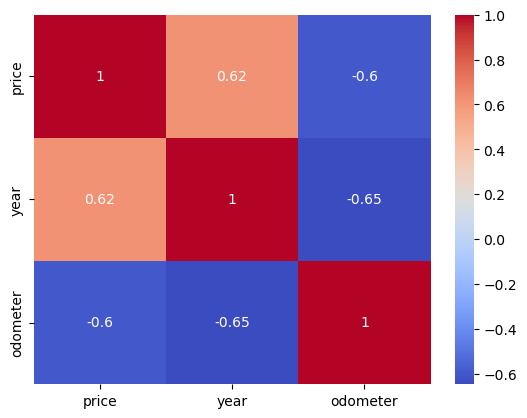

In [169]:
# We will look at the correlation of numerical features

correlation = overall_data_outlier_removed.corr(numeric_only = True)
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

From the correlation plot, we can see that price is positively correlated with year and negatively correlated with odometer. Now we will transform the categorical columns.

In [170]:
# Feature Groups
categorical_features = ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size']
frequency_features = ['region', 'manufacturer', 'model', 'type', 'paint_color', 'state']
ordinal_features = ['condition']
numerical_features = ['odometer', 'price', 'year']

# Transformers
onehot_transformer = OneHotEncoder(drop = 'first', sparse_output = False) # drop first feature to handle multicollinearity though it may not completely remove it.
frequency_transformer = FrequencyEncoder()
ordinal_transformer = OrdinalEncoder(mapping={
    'new': 6,
    'like new': 5,
    'excellent': 4,
    'good': 3,
    'fair': 2,
    'salvage': 1,
    'unknown': 0
})

# Scaler
scaler = StandardScaler()

# ColumnTransformer: Applying transformations and scaling inside pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, categorical_features),
        
        ('frequency', Pipeline([
            ('frequency_encoder', frequency_transformer),
            ('scaler', scaler)
        ]), frequency_features),

        ('ordinal', Pipeline([
            ('ordinal_encoder', ordinal_transformer),
            ('scaler', scaler)
        ]), ordinal_features),
        
        ('scaler', scaler, numerical_features)
    ]
)

# Applying transformation
overall_data_transformed = preprocessor.fit_transform(overall_data_outlier_removed)

# Extracting transformed column names
encoded_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features)
overall_transformed_columns = list(encoded_columns) + frequency_features + ordinal_features + numerical_features

# Converting the transformed data back to a DataFrame
overall_data_transformed_df = pd.DataFrame(overall_data_transformed, columns=overall_transformed_columns, index=overall_data_outlier_removed.index)

# Displaying the transformed data
overall_data_transformed_df.head()


C:\Users\kusha\AppData\Local\Temp\ipykernel_16476\3297966725.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)


,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,cylinders_unknown,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,fuel_unknown,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,title_status_unknown,transmission_manual,transmission_other,transmission_unknown,drive_fwd,drive_rwd,drive_unknown,size_full-size,size_mid-size,size_sub-compact,size_unknown,region,manufacturer,model,type,paint_color,state,condition,odometer,price,year
27,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.816723,-0.568683,0.930085,-0.669407,0.257181,-0.865308,0.424619,-0.653880,1.546207,0.281620
28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.816723,1.081987,2.826641,-0.669407,-1.031549,-0.865308,0.424619,-0.391284,0.489128,-0.568564
29,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.816723,1.081987,2.826641,-0.669407,-1.089657,-0.865308,0.424619,-1.418873,2.122795,1.556896
30,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.816723,0.373831,-0.008647,-0.669407,-1.089657,-0.865308,0.424619,-0.985411,1.296352,0.919258
31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.816723,1.795704,3.075917,-1.167383,-0.093297,-0.865308,0.977792,0.729099,-0.240256,0.069074


The final dataset is ready for modeling. We will assign the final data to dataset variable and reset the index of the dataset.

In [171]:
dataset = overall_data_transformed_df.reset_index(drop = True)

We will check whether the dataset is sparse or not since sparse matrix is not good for modeling. Algorithms like linear regression, kNN, and tree-based models may struggle with sparse data, leading to poor generalization and biased predictions. If too many features have zero values, the model may fail to capture meaningful patterns.

In [172]:
# Check if the resulting DataFrame is sparse

is_sparse = any(isinstance(dtype, pd.SparseDtype) for dtype in dataset.dtypes)
print(f"Is the DataFrame sparse? {is_sparse}")

Is the DataFrame sparse? False


Highly correlated features can make it difficult to interpret which feature truly influences the target variable. In Linear Regression, Logistic Regression, and other parametric models, multicollinearity leads to large standard errors and unreliable coefficients.
Highly correlated variables contribute redundant information, increasing model complexity without adding value. 
Removing them can help prevent overfitting and improve generalization. while multicollinearity is a problem for linear models, 
tree-based models are more robust to it and do not typically suffer from the same issues. We will use VIF metric to find multicollinearity among features.

The Variance Inflation Factor (VIF) suggests the following:

Interpreting VIF Values
VIF of 1: Indicates that the feature is not correlated with other features. It does not suffer from multicollinearity.

VIF between 1 and 5: Generally considered low multicollinearity, meaning the feature is reasonably independent.

VIF between 5 and 10: Indicates moderate multicollinearity, meaning the feature is somewhat correlated with other features.

VIF above 10: Suggests high multicollinearity, meaning the feature is highly correlated with others and should likely be considered for removal or further investigation.

How to handle multicollinearity:

Remove or Combine High VIF Features:
Consider removing or combining the highly collinear features to reduce multicollinearity.

In [173]:
# Multicollinearity Check using Variance Inflation Factor (VIF)

overall_data_vif = dataset.drop(columns = 'price')
vif_data = pd.DataFrame()
vif_data["Feature"] = overall_data_vif.columns
vif_data["VIF"] = [variance_inflation_factor(overall_data_vif.values, i) for i in range(overall_data_vif.shape[1])]

print("\nVariance Inflation Factor (VIF) for Each Feature:")
print(vif_data)


Variance Inflation Factor (VIF) for Each Feature:
                    Feature        VIF
0    cylinders_12 cylinders   1.011943
1     cylinders_3 cylinders   1.051928
2     cylinders_4 cylinders  10.256187
3     cylinders_5 cylinders   1.211957
4     cylinders_6 cylinders  11.916782
5     cylinders_8 cylinders   7.399995
6           cylinders_other   1.096750
7         cylinders_unknown  20.291006
8             fuel_electric   1.153075
9                  fuel_gas  23.395491
10              fuel_hybrid   1.401716
11               fuel_other   3.219346
12             fuel_unknown   1.207993
13        title_status_lien   1.009999
14     title_status_missing   1.000684
15  title_status_parts only   1.000219
16     title_status_rebuilt   1.041638
17     title_status_salvage   1.015244
18     title_status_unknown   1.101340
19      transmission_manual   1.103983
20       transmission_other   2.088435
21     transmission_unknown   1.014834
22                drive_fwd   2.404650
23           

In [174]:
# Manually dropping features to handle multicollinearity

dataset.drop(columns = ['size_unknown', 'cylinders_unknown', 'fuel_other'], inplace = True)

In [175]:
# Now, we will check for multicollinearity again to verify that we successfully handled this issue

overall_data_vif = dataset.drop(columns = 'price')
vif_data = pd.DataFrame()
vif_data["Feature"] = overall_data_vif.columns
vif_data["VIF"] = [variance_inflation_factor(overall_data_vif.values, i) for i in range(overall_data_vif.shape[1])]

print("\nVariance Inflation Factor (VIF) for Each Feature:")
print(vif_data)


Variance Inflation Factor (VIF) for Each Feature:
                    Feature       VIF
0    cylinders_12 cylinders  1.002478
1     cylinders_3 cylinders  1.007867
2     cylinders_4 cylinders  2.058890
3     cylinders_5 cylinders  1.027630
4     cylinders_6 cylinders  1.944681
5     cylinders_8 cylinders  1.795129
6           cylinders_other  1.026324
7             fuel_electric  1.046200
8                  fuel_gas  4.771065
9               fuel_hybrid  1.084129
10             fuel_unknown  1.074171
11        title_status_lien  1.009477
12     title_status_missing  1.000645
13  title_status_parts only  1.000151
14     title_status_rebuilt  1.041205
15     title_status_salvage  1.014699
16     title_status_unknown  1.099273
17      transmission_manual  1.097373
18       transmission_other  1.793370
19     transmission_unknown  1.013497
20                drive_fwd  2.134471
21                drive_rwd  1.480139
22            drive_unknown  2.105145
23           size_full-size  1.568045

We have successfully handled the multicollinearity issue (for linear models) on the dataset. The dataset is ready for modeling.

In [176]:
data.shape

(390581, 16)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [177]:
# Features and Target

X = dataset.drop(columns = ['price'])  # Features
y = dataset['price']  # Target variable


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Different Baseline Regression Models with random hyperparameters

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators = 100, max_depth = 10, min_samples_split = 10, n_jobs = -1, random_state = 42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.05, max_depth = 5, random_state = 42),
    "XGBoost": XGBRegressor(n_estimators = 300, learning_rate = 0.05, max_depth = 6, subsample = 0.8, colsample_bytree = 0.8, 
                                                                                                n_jobs = -1, random_state = 42),
    # "SVR": SVR(C = 1, kernel = 'rbf', epsilon = 0.1)
}


# Training and cross validation

results = []
train_mse_values = []
test_mse_values = []
cv_mse_values = []
model_names = []

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)  # 5-Fold Cross-Validation

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation scores (Negative MSE)

    cv_mse = -cross_val_score(model, X_train, y_train, cv = kf, scoring = 'neg_mean_squared_error', n_jobs = -1)
    avg_cv_mse = np.mean(cv_mse)
    
    # Training model on full training set

    model.fit(X_train, y_train)
    
    # Predictions

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Computing Errors

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(test_mse)
    r2 = r2_score(y_test, y_test_pred)

    results.append((name, avg_cv_mse, test_mse, rmse, r2))
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)
    cv_mse_values.append(avg_cv_mse)
    model_names.append(name)

    print(f"{name} - CV MSE: {avg_cv_mse:.4f}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


# Converting results to DataFrame

results_df = pd.DataFrame(results, columns = ['Model', 'Train MSE', 'Test MSE', 'RMSE', 'R2']).sort_values(by = 'Test MSE')


Training Linear Regression...
Linear Regression - CV MSE: 0.3197, Train MSE: 0.3196, Test MSE: 0.3169, RMSE: 0.5629, R²: 0.6839

Training Random Forest...
Random Forest - CV MSE: 0.2056, Train MSE: 0.1989, Test MSE: 0.2058, RMSE: 0.4536, R²: 0.7947

Training Gradient Boosting...
Gradient Boosting - CV MSE: 0.1756, Train MSE: 0.1742, Test MSE: 0.1778, RMSE: 0.4217, R²: 0.8226

Training XGBoost...
XGBoost - CV MSE: 0.1360, Train MSE: 0.1312, Test MSE: 0.1365, RMSE: 0.3694, R²: 0.8638


The results of baseline models without hyperparamter tuning are as follows:

In [179]:
# Baseline Metrics
results_df

,Model,Train MSE,Test MSE,RMSE,R2
3,XGBoost,0.135989,0.136478,0.369429,0.863847
2,Gradient Boosting,0.175638,0.177840,0.421711,0.822584
1,Random Forest,0.205555,0.205780,0.453630,0.794711
0,Linear Regression,0.319748,0.316902,0.562941,0.683854


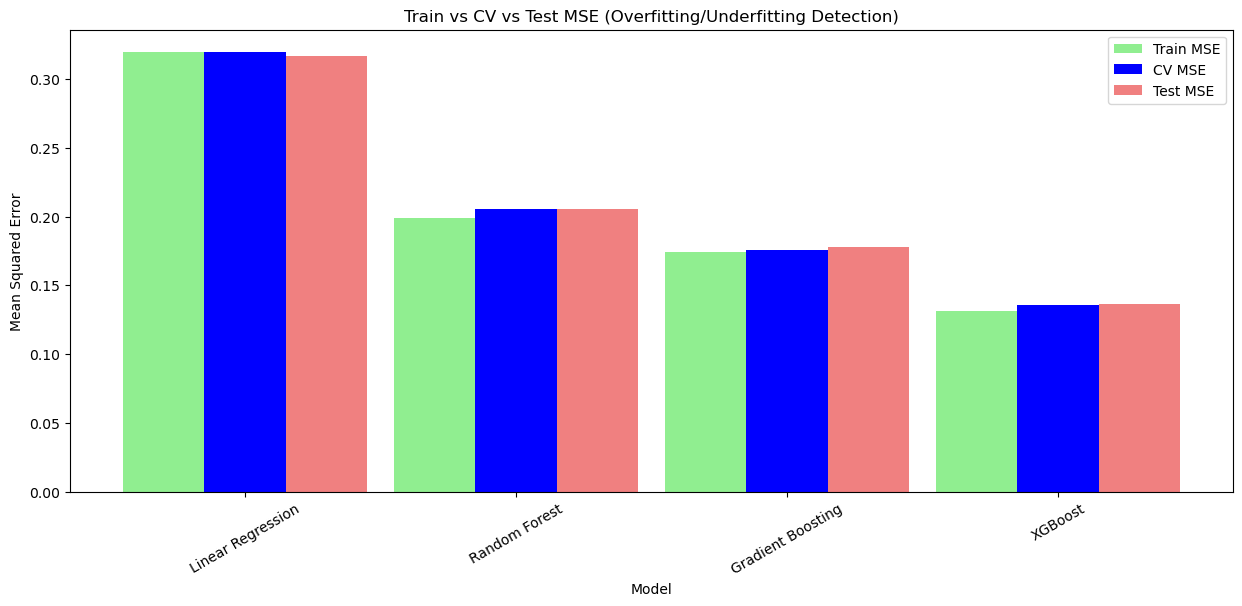

In [180]:
plt.figure(figsize = (15, 6))

x_pos = np.arange(len(model_names))
plt.bar(x_pos - 0.3, train_mse_values, width = 0.3, label = 'Train MSE', color = 'lightgreen')
plt.bar(x_pos, cv_mse_values, width = 0.3, label = 'CV MSE', color = 'blue')
plt.bar(x_pos + 0.3, test_mse_values, width = 0.3, label = 'Test MSE', color = 'lightcoral')
plt.xticks(x_pos, model_names, rotation = 30)
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.title("Train vs CV vs Test MSE (Overfitting/Underfitting Detection)")
plt.legend()
plt.show()

The Linear Regression model in this case appears to exhibit underfitting, as evidenced by the relatively high training and test MSE values (0.319748 and 0.316902, respectively) and lower R-squared values (0.683854 for training and 0.562941 for testing). While the model explains a moderate amount of variance in the training data, it struggles to generalize well to unseen data, as indicated by the significant drop in R² on the test set. This performance is notably inferior compared to more complex models like XGBoost, Gradient Boosting, and Random Forest, which achieve significantly better scores in both metrics. The model's inability to capture enough of the underlying patterns in the data suggests that more sophisticated techniques or feature engineering might be necessary to improve its performance and make it more suitable for this particular dataset.

We will perform diagnostic of Linear Regression model using plots and metrics

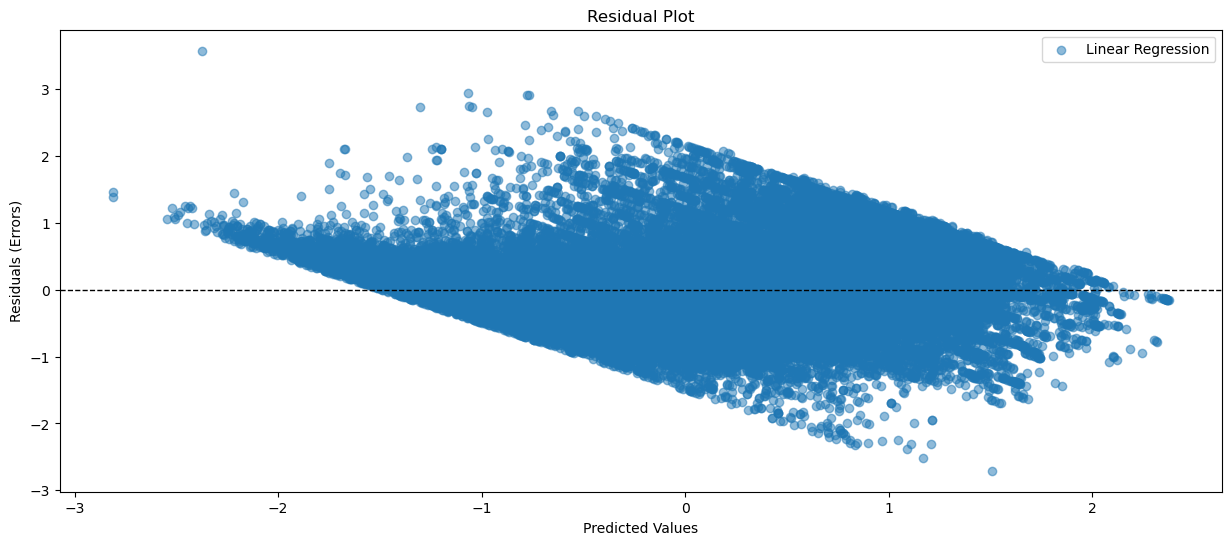

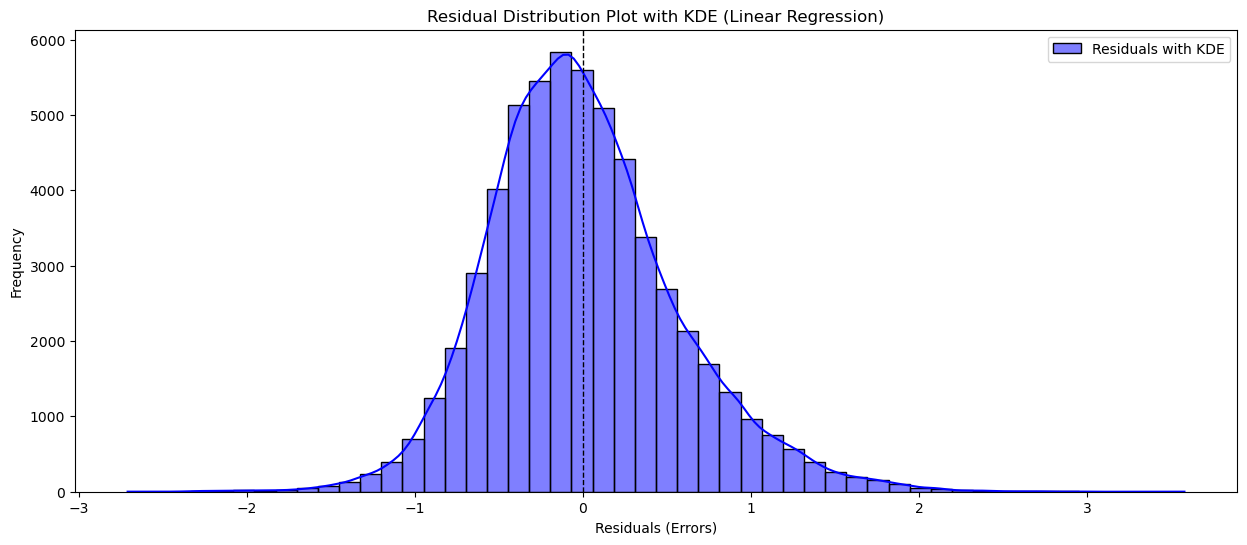

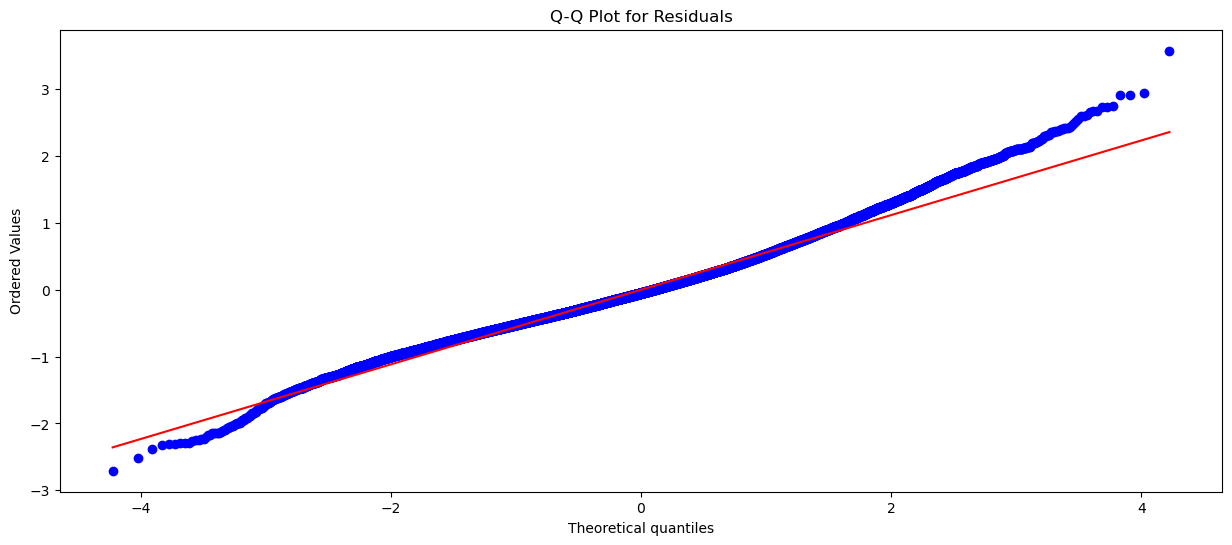

Skewness: 0.4899, Kurtosis: 0.9013


In [181]:
#  Linear Regression Residual Plot

linear_model = models["Linear Regression"]

plt.figure(figsize = (15, 6))
y_test_pred = linear_model.predict(X_test)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha = 0.5, label = 'Linear Regression')
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot")
plt.legend()
plt.show()

plt.figure(figsize = (15, 6))

if "Linear Regression" in models:
    linear_model = models["Linear Regression"]
    y_test_pred = linear_model.predict(X_test)
    residuals = y_test - y_test_pred
    
    # Plotting histogram and KDE (Kernel Density Estimate)
    sns.histplot(residuals, kde = True, color = "blue", bins = 50, alpha = 0.5, label = "Residuals with KDE")
    plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 1)
    plt.xlabel("Residuals (Errors)")
    plt.ylabel("Frequency")
    plt.title("Residual Distribution Plot with KDE (Linear Regression)")
    plt.legend()
    plt.show()

# Q-Q Plot

plt.figure(figsize=(15, 6))

stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("Q-Q Plot for Residuals")
plt.show()


# Skewness and Kurtosis

skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)

print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")

The residual plot shows some type of plane structure that is some systematic pattern, this indicates that the linear regression model may not be fully capturing the relationship between the predictors and the response variable. The linear regression model assumes a linear relationship between the predictors and the response. If the residuals show a structured pattern, it implies that the model is not correctly specified.

From the residual distribution plot, we can see that the residuals are not centered around zero suggesting that linear regression model is biased and systematically mispredicting the response. This could be due to many reasons but not limited to missing predictors, non-linear relationships, outliers, or incorrect transformations.

The Q-Q plot indicates that the residuals are approximately normally distributed in the central range (-2 to 2) but deviate in the tails. This suggests that the normality assumption is partially violated.

The skewness (0.4899) and kurtosis (0.9013) values indicate that the residuals are moderately positively skewed and have lighter tails than a normal distribution. This suggests that the normality assumption of linear regression is not fully satisfied, and the model may be systematically underpredicting some values.

We will futher diagnos the linear regression model by conducting test for Normality.


In [182]:
# 3. Anderson-Darling Test for Normality
anderson_result = stats.anderson(residuals, dist = 'norm')
print(f"Anderson-Darling Test Statistic: {anderson_result.statistic:.4f}")
print(f"Critical Values: {anderson_result.critical_values}")
print(f"Significance Levels: {anderson_result.significance_level}")

Anderson-Darling Test Statistic: 240.8608
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


Test Statistic: 240.8608 is much larger than any of the critical values at the 15%, 10%, 5%, 2.5%, and 1% significance levels.
Therefore, we reject the null hypothesis that the data follows the assumed distribution (e.g., normal distribution) at all of the provided significance levels.This suggests that the data is significantly different from the assumed distribution.

Now, we will also examine whether the residuals from regression model have a systematic patten in their variance by using Breusch-Pagan Test and White test.

Breusch-Pagan Test Statistic: 22932.397987904595, p-value: 0.0
White Test Statistic: 41097.858742010205, p-value: 0.0


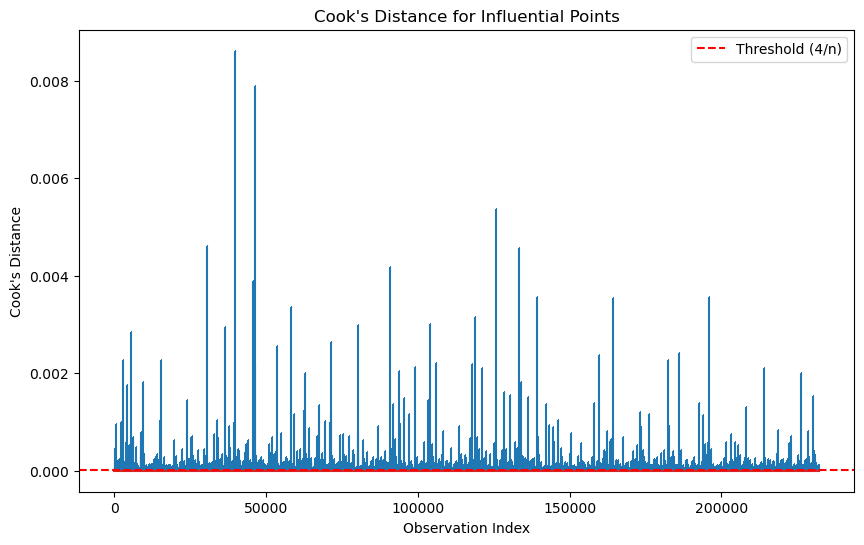

Influential Points (Index): [   121    129    134 ... 232074 232077 232093]
Number of influential points: 9545


In [183]:

# Fit statsmodels OLS model to get influence measures
ols_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
influence = ols_model.get_influence()

# Perform Breusch-Pagan test

test_result = sms.het_breuschpagan(ols_model.resid, ols_model.model.exog)
bp_test_statistic, bp_p_value = test_result[0], test_result[1]
print(f"Breusch-Pagan Test Statistic: {bp_test_statistic}, p-value: {bp_p_value}")


# Perform White test for heteroscedasticity

white_test_statistic, white_p_value, _, _ = het_white(ols_model.resid, ols_model.model.exog)
print(f"White Test Statistic: {white_test_statistic}, p-value: {white_p_value}")

# Compute Cook's Distance
cooks_d, p_values = influence.cooks_distance

# Visualizing Cook’s Distance
plt.figure(figsize = (10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt = ",")
plt.axhline(4 / len(X_train), color = "r", linestyle = "--", label = "Threshold (4/n)")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Influential Points")
plt.legend()
plt.show()

# Identifying Influential Points
influential_points = np.where(cooks_d > (4 / len(X_train)))[0]
print(f"Influential Points (Index): {influential_points}")

# Count the number of influential points
num_influential = np.sum(cooks_d > (4 / len(X_train)))

print(f"Number of influential points: {num_influential}")


The results of the diagnostic tests on the regression model indicate significant issues with heteroscedasticity and influential points. The Breusch-Pagan test yielded a test statistic of 22932.40 with a p-value of 0.0, and the White test produced a test statistic of 41097.86 with a p-value of 0.0, both indicating strong evidence of heteroscedasticity in the residuals. This suggests that the variance of the residuals is not constant, violating a key assumption of linear regression. Additionally, the Cook's Distance analysis identified 9545 influential points, which have a significant impact on the regression model. These influential points need to be investigated further to understand their effect on the model. We can further improve the Linear Regression model by addressing these influential points.

Given these findings, it is clear that Linear Regression may not be suitable for this dataset, and alternative modeling approaches, such as robust regression techniques or non-linear models, should be considered to improve the model's accuracy and reliability.

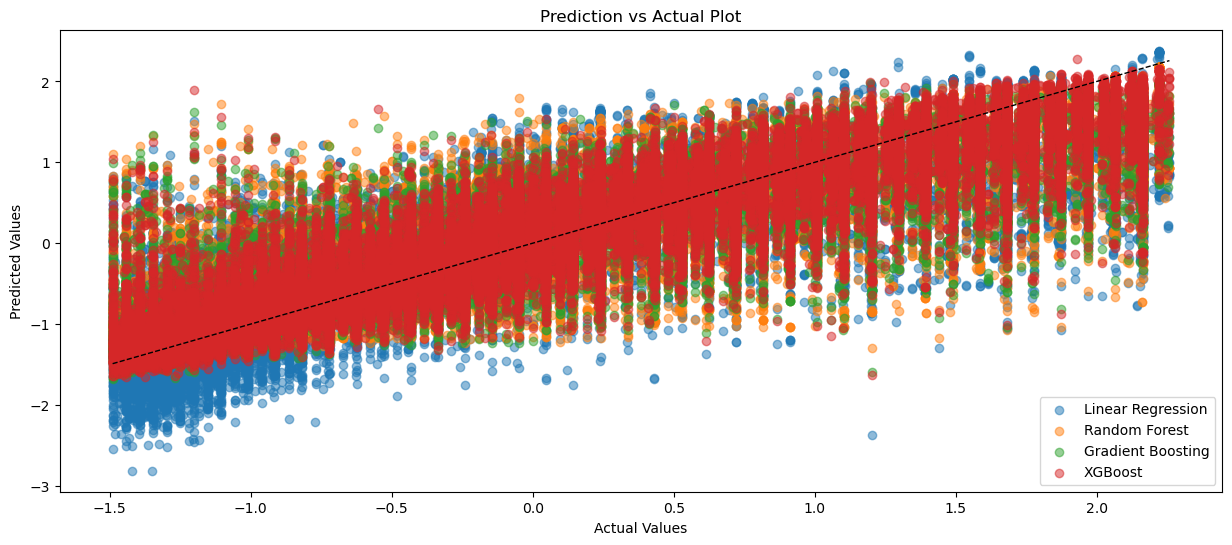

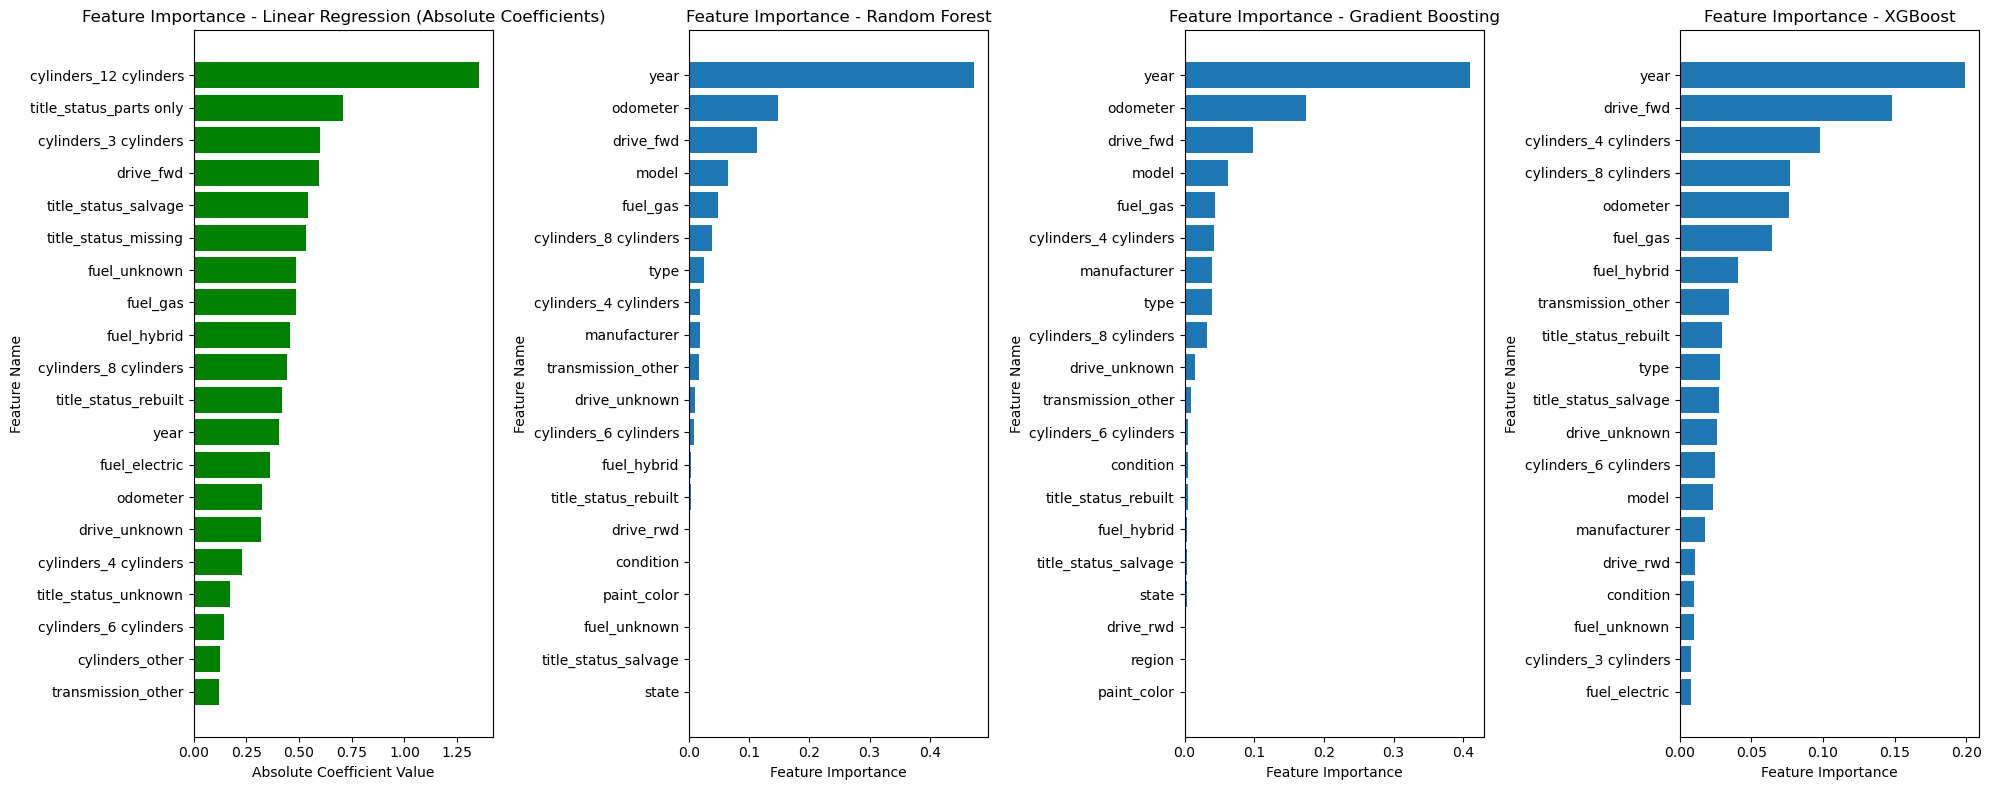

In [184]:
# Prediction vs Actual Plot (Model Accuracy)

plt.figure(figsize = (15, 6))

for name, model in models.items():
    y_test_pred = model.predict(X_test)
    plt.scatter(y_test, y_test_pred, alpha = 0.5, label = name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual Plot")
plt.legend()
plt.show()

# Set up the figure with multiple subplots (side-by-side)

fig, axes = plt.subplots(1, len(models), figsize=(20, 8))  # Adjust the number of columns based on the number of models

# Loop through the models and plot on each axis
for i, (name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importance = model.feature_importances_
        indices = np.argsort(importance)[-20:]  # Top 15 features
        
        # Plot feature importance on the respective subplot
        axes[i].barh(X_train.columns[indices], importance[indices])
        axes[i].set_xlabel("Feature Importance")
        axes[i].set_ylabel("Feature Name")
        axes[i].set_title(f"Feature Importance - {name}")
    elif name == "Linear Regression":
        # For Linear Regression, plot the absolute coefficients
        coefficients = model.coef_
        absolute_coefficients = np.abs(coefficients)
        indices = np.argsort(absolute_coefficients)[-20:]  # Top 20 most important features based on magnitude
        axes[i].barh(X_train.columns[indices], absolute_coefficients[indices], color = 'green')
        axes[i].set_xlabel("Absolute Coefficient Value")
        axes[i].set_ylabel("Feature Name")
        axes[i].set_title(f"Feature Importance - {name} (Absolute Coefficients)")

plt.tight_layout()
plt.show()


Random Forest, Gradient Boosting, and XGBoost are non-linear models and generally do not make assumptions about homoscedasticity (constant variance of the residuals). So, we will use Randomized search to find better hyperparameters than the ones randomly selected above, get the feature importance, discard Linear Regression Model.

In [185]:
# Define the hyperparameters to sample for each model

param_distributions = {
    "Linear Regression": {},  # No hyperparameters to tune
    
    "Random Forest": {
        'n_estimators': randint(100, 500),  # Randomly sample from 100 to 500
        'max_depth': randint(5, 20),  # Randomly sample max_depth from 5 to 20
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'bootstrap': [True, False]  # Choose between True or False
    },
    
    "Gradient Boosting": {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.1),  # Uniform distribution between 0.01 and 0.1
        'max_depth': randint(3, 10),
        'subsample': uniform(0.7, 0.3),  # Subsample between 0.7 and 1.0
        'min_samples_split': randint(2, 10)
    },
    
    "XGBoost": {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.1),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'gamma': uniform(0, 0.1)
    }
}

# Initialize RandomizedSearchCV with Cross-Validation

best_models = {}  # To store the best model for each algorithm
results = []  # To store evaluation metrics

for name, model in models.items():
    print(f"\nTraining and tuning {name}...")

    # Define RandomizedSearchCV for each model

    random_search = RandomizedSearchCV(estimator = model, param_distributions = param_distributions[name], 
                                       n_iter = 10, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose = 1, random_state = 42)
    
    # Fit the RandomizedSearchCV to the data

    random_search.fit(X_train, y_train)

    # Best parameters and best score from RandomizedSearchCV

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    best_models[name] = best_model  # Save the best model

    # Train and predict using the best model

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Compute errors and metrics

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(test_mse)
    r2 = r2_score(y_test, y_test_pred)

    # Append results

    results.append((name, best_params, best_score, train_mse, test_mse, rmse, r2))

    print(f"{name} - Best Params: {best_params}, CV Best Score: {best_score:.4f}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")



Training and tuning Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\kusha\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Linear Regression - Best Params: {}, CV Best Score: -0.3198, Train MSE: 0.3196, Test MSE: 0.3169, RMSE: 0.5629, R²: 0.6839

Training and tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest - Best Params: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 287}, CV Best Score: -0.1206, Train MSE: 0.0915, Test MSE: 0.1174, RMSE: 0.3426, R²: 0.8829

Training and tuning Gradient Boosting...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Gradient Boosting - Best Params: {'learning_rate': 0.09661761457749352, 'max_depth': 6, 'min_samples_split': 9, 'n_estimators': 251, 'subsample': 0.8952665418846558}, CV Best Score: -0.1140, Train MSE: 0.1060, Test MSE: 0.1132, RMSE: 0.3364, R²: 0.8871

Training and tuning XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost - Best Params: {'colsample_bytree': 0.7061753482887407, 'gamma': 0.09699098521619944, 'learning_rate

In [186]:
results_df = pd.DataFrame(results, columns = ['Model', 'Best Params', 'CV Best Score', 'Train MSE', 'Test MSE', 'RMSE', 'R2'])
results_df = results_df.sort_values(by = 'Test MSE')
results_df

,Model,Best Params,CV Best Score,Train MSE,Test MSE,RMSE,R2
3,XGBoost,"{'colsample_bytree': 0.7061753482887407, 'gamm...",-0.073072,0.051378,0.070449,0.265422,0.929719
2,Gradient Boosting,"{'learning_rate': 0.09661761457749352, 'max_de...",-0.114018,0.106047,0.113191,0.336438,0.887079
1,Random Forest,"{'bootstrap': True, 'max_depth': 15, 'min_samp...",-0.120633,0.091547,0.117377,0.342604,0.882903
0,Linear Regression,{},-0.319765,0.319633,0.316902,0.562941,0.683854


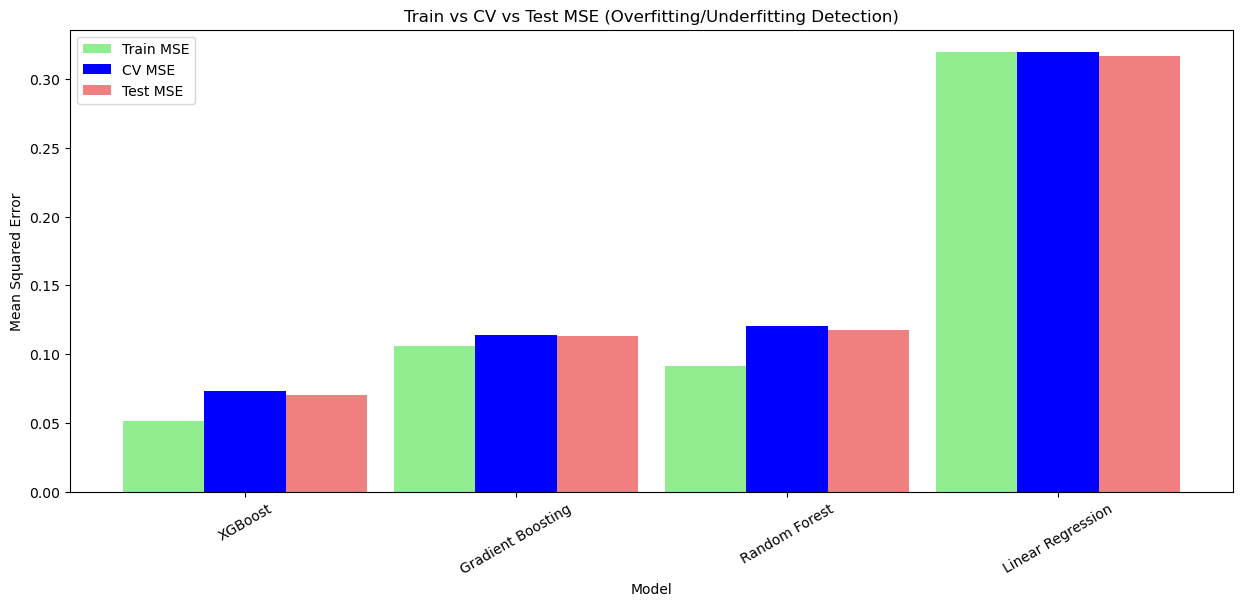

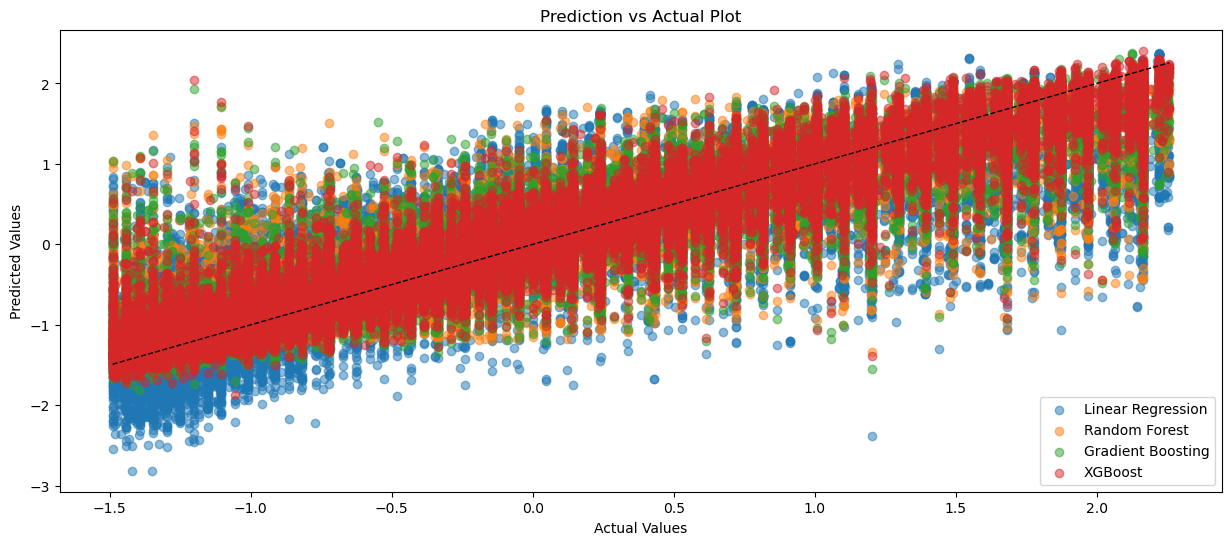

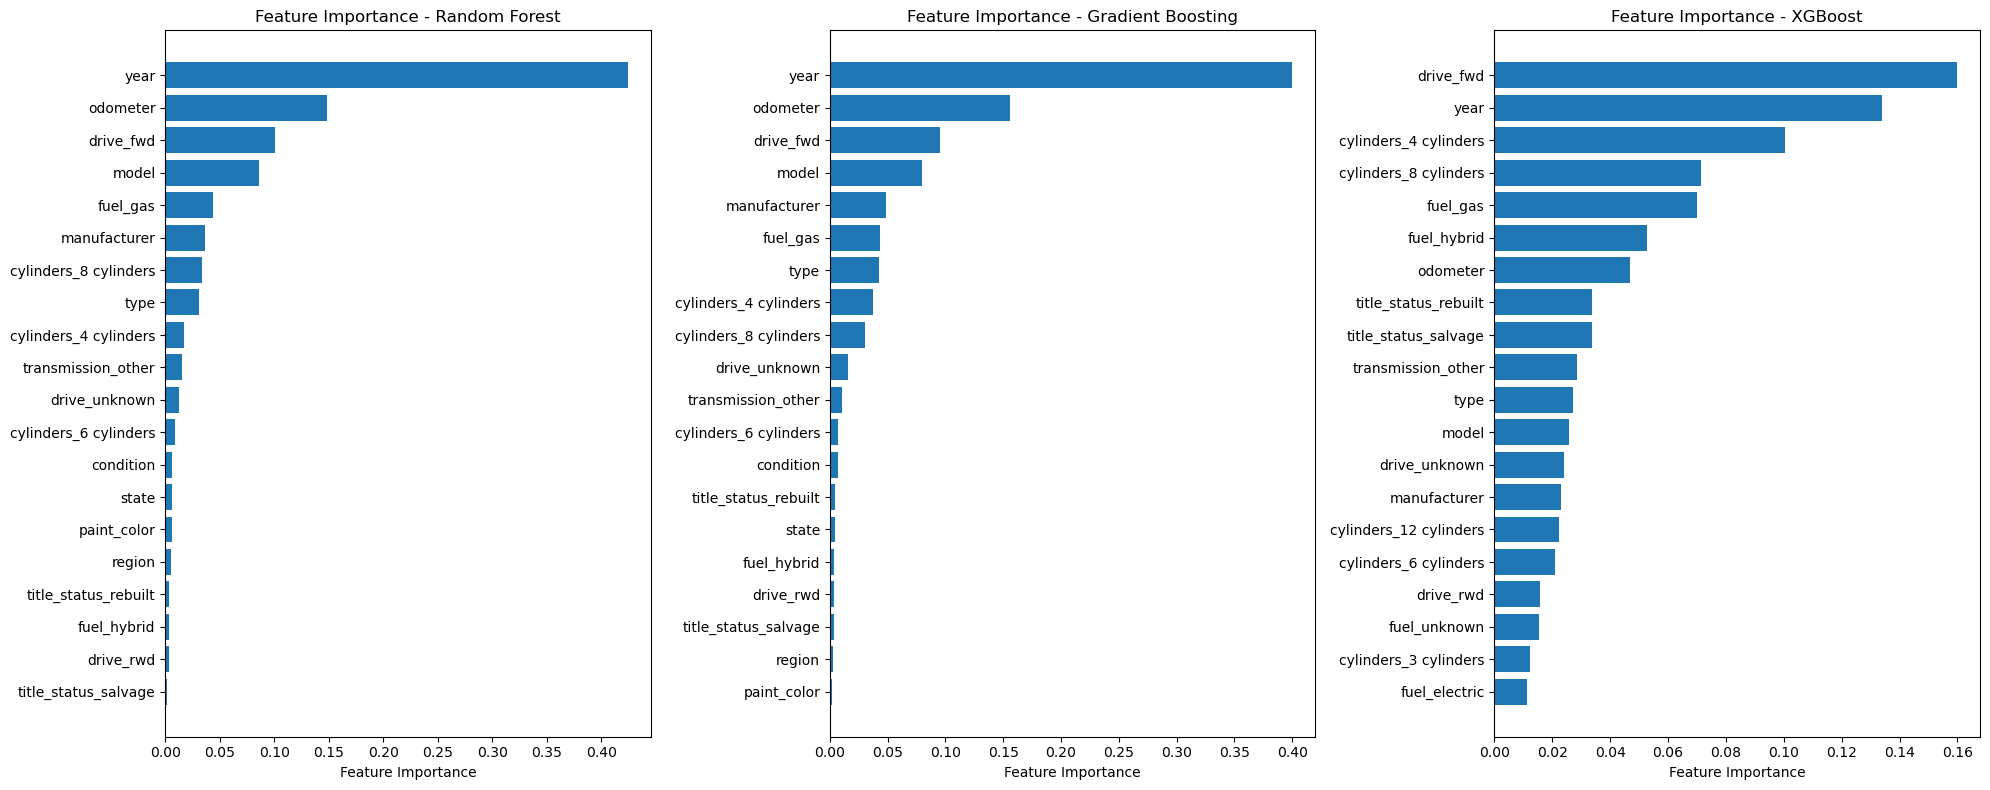

In [187]:
# Extracting MSE values from results_df

train_mse_values = results_df["Train MSE"]
cv_mse_values = -results_df["CV Best Score"]  # Convert negative MSE to positive
test_mse_values = results_df["Test MSE"]
model_names = results_df["Model"]

# Train vs Test vs CV MSE Plot

plt.figure(figsize = (15, 6))
x_pos = np.arange(len(model_names))
plt.bar(x_pos - 0.3, train_mse_values, width = 0.3, label = "Train MSE", color = "lightgreen")
plt.bar(x_pos, cv_mse_values, width = 0.3, label = "CV MSE", color = "blue")
plt.bar(x_pos + 0.3, test_mse_values, width = 0.3, label = "Test MSE", color = "lightcoral")
plt.xticks(x_pos, model_names, rotation = 30)
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.title("Train vs CV vs Test MSE (Overfitting/Underfitting Detection)")
plt.legend()
plt.show()

# Prediction vs Actual Plot

plt.figure(figsize = (15, 6))
for name, model in best_models.items():
    y_test_pred = model.predict(X_test)
    plt.scatter(y_test, y_test_pred, alpha = 0.5, label = name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = "black", linestyle = "--", linewidth = 1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual Plot")
plt.legend()
plt.show()

# Feature Importance Plot

fig, axes = plt.subplots(1, sum(hasattr(model, "feature_importances_") for model in best_models.values()), figsize=(20, 8))

# Iterate over models and plot feature importance only if applicable
plot_index = 0
for name, model in best_models.items():
    if hasattr(model, "feature_importances_"):  # Check if model has feature importances
        importance = model.feature_importances_
        indices = np.argsort(importance)[-20:]  # Get top 20 features
        axes[plot_index].barh(X_train.columns[indices], importance[indices])
        axes[plot_index].set_xlabel("Feature Importance")
        axes[plot_index].set_title(f"Feature Importance - {name}")
        plot_index += 1  # Move to next subplot

plt.tight_layout()
plt.show()



The analysis of the four models—Linear Regression, Random Forest, Gradient Boosting, and XGBoost—reveals that XGBoost is the best-performing model for this dataset, achieving the highest R² (0.9297) and the lowest Test MSE (0.0704) and RMSE (0.2654). Gradient Boosting and Random Forest also demonstrate strong performance, with Gradient Boosting slightly outperforming Random Forest in terms of Test MSE and R². Linear Regression, on the other hand, performs significantly worse, indicating that the relationship between the features and the target is likely non-linear. While XGBoost shows some overfitting, it generalizes exceptionally well to the test set, making it the preferred choice. To further improve the model, we will select features and use ensemble method "Stacking with a meta-learner" which is an advanced ensemble technique that combines the predictions of multiple base models (Random Forest, Gradient Boosting, XGBoost) using a meta-learner (a higher-level model) to improve overall performance.

In [ ]:
# Initialize a dictionary to store feature importances from all models
feature_importance_dict = {}

# Loop through each model and extract feature importances
for model_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    if hasattr(best_models[model_name], "feature_importances_"):  # Ensure model has feature importance
        feature_importance_dict[model_name] = best_models[model_name].feature_importances_

feature_importance_df = pd.DataFrame(feature_importance_dict, index = X_train.columns)

# Compute median importance across all models
feature_importance_df["Median Importance"] = feature_importance_df.median(axis = 1)

# Compute the median threshold
median_threshold = feature_importance_df["Median Importance"].median()

# Select features above or equal to the median threshold
selected_features = feature_importance_df[feature_importance_df["Median Importance"] >= median_threshold].index.tolist()

# Subset the dataset with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Number of selected features: {len(selected_features)}")
print("Selected Features:", selected_features)

Number of selected features: 18
Selected Features: ['cylinders_4 cylinders', 'cylinders_6 cylinders', 'cylinders_8 cylinders', 'fuel_gas', 'fuel_hybrid', 'title_status_rebuilt', 'transmission_other', 'drive_fwd', 'drive_rwd', 'drive_unknown', 'manufacturer', 'model', 'type', 'paint_color', 'state', 'condition', 'odometer', 'year']


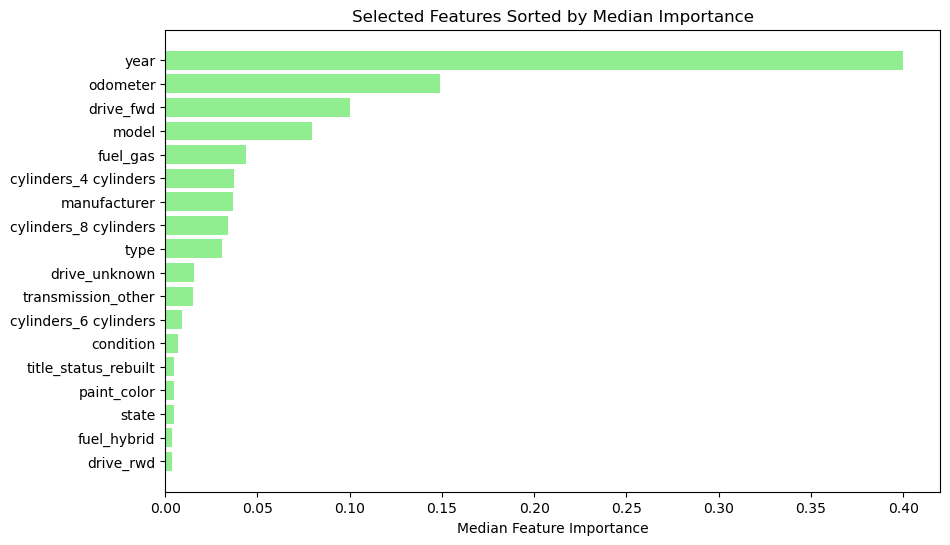

In [ ]:
# Create a dataframe with selected features and their median importance
selected_features_df = feature_importance_df.loc[selected_features]

# Sort by median importance in descending order
selected_features_sorted = selected_features_df.sort_values(by="Median Importance", ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_features_sorted.index, selected_features_sorted["Median Importance"], color='lightgreen')
plt.xlabel("Median Feature Importance")
plt.title("Selected Features by Median Importance")
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()


After using the tuned models (Random Forest, Gradient Boosting, and XGBoost) to assess feature importance, 18 features were selected based on their median importance across all models. These selected features include categorical variables such as cylinder type, fuel type, title status, transmission, drive type, and manufacturer, along with continuous variables like odometer and year. The final selected features are: ['cylinders_4 cylinders', 'cylinders_6 cylinders', 'cylinders_8 cylinders', 'fuel_gas', 'fuel_hybrid', 'title_status_rebuilt', 'transmission_other', 'drive_fwd', 'drive_rwd', 'drive_unknown', 'manufacturer', 'model', 'type', 'paint_color', 'state', 'condition', 'odometer', 'year']

In [197]:
# Initializing dictionary to store retrained models and results

best_models_selected = {}
results_selected = []

# Retraining models on the selected features

for name, model in best_models.items():
    print(f"\nRetraining {name} with selected features...")

    # Fitting the model on the reduced feature set

    model.fit(X_train_selected, y_train)

    # Saving the retrained model

    best_models_selected[name] = model

    # Predicting on train and test sets

    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Computing performance metrics

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(test_mse)
    r2 = r2_score(y_test, y_test_pred)

    # Appending results to list

    results_selected.append((name, train_mse, test_mse, rmse, r2))

    print(f"{name} - Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Converting results list to DataFrame

results_selected_df = pd.DataFrame(results_selected, columns = ["Model", "Train MSE", "Test MSE", "RMSE", "R2"])

# Sorting the results

results_selected_df = results_selected_df.sort_values(by = "Test MSE")

print("\nPerformance after Feature Selection:")
print(results_selected_df)



Retraining Linear Regression with selected features...
Linear Regression - Train MSE: 0.3270, Test MSE: 0.3234, RMSE: 0.5687, R²: 0.6773

Retraining Random Forest with selected features...
Random Forest - Train MSE: 0.0910, Test MSE: 0.1160, RMSE: 0.3405, R²: 0.8843

Retraining Gradient Boosting with selected features...
Gradient Boosting - Train MSE: 0.1049, Test MSE: 0.1120, RMSE: 0.3346, R²: 0.8883

Retraining XGBoost with selected features...
XGBoost - Train MSE: 0.0522, Test MSE: 0.0711, RMSE: 0.2666, R²: 0.9291

Performance after Feature Selection:
               Model  Train MSE  Test MSE      RMSE        R2
3            XGBoost   0.052208  0.071056  0.266564  0.929113
2  Gradient Boosting   0.104882  0.111967  0.334614  0.888301
1      Random Forest   0.091047  0.115970  0.340544  0.884306
0  Linear Regression   0.327006  0.323448  0.568725  0.677324


After performing feature selection, the model performance improved noticeably. The XGBoost model emerged as the top performer, achieving the lowest test MSE (0.0711), RMSE (0.2666), and the highest R-squared of 0.9291, demonstrating its ability to effectively capture patterns in the data. Gradient Boosting and Random Forest also showed strong results, with R-squared values of 0.8883 and 0.8843, respectively, indicating their high predictive power. On the other hand, Linear Regression, being a simpler model, lagged behind with a lower R-squared of 0.6773. Overall, the feature selection process enhanced the model performance, particularly for tree-based models, suggesting that these models are more suited for this dataset.

In [198]:
# Defining base models with selected features

base_models = [
    ('xgb', best_models_selected['XGBoost']),
    ('gb', best_models_selected['Gradient Boosting']),
    ('rf', best_models_selected['Random Forest'])
]

# Preparing meta-learning dataset (Base model predictions as features)

meta_features_train = np.column_stack([model.predict(X_train_selected) for _, model in base_models])
meta_features_test = np.column_stack([model.predict(X_test_selected) for _, model in base_models])

# Defining GridSearchCV to tune alpha for Ridge meta-learner

param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(Ridge(), param_grid, cv = 5, scoring = 'r2', n_jobs = -1)
grid_search.fit(meta_features_train, y_train)

# Best alpha for Ridge

best_alpha = grid_search.best_params_['alpha']

# Defining the final Ridge meta-learner with best alpha

meta_learner = Ridge(alpha = best_alpha)

# Creating Stacking Regressor

stacking_model = StackingRegressor(estimators = base_models, final_estimator = meta_learner, n_jobs = -1)

# Performing K-Fold Cross-Validation on selected features

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(stacking_model, X_train_selected, y_train, cv = kf, scoring = 'r2', n_jobs = -1)

# Training the final Stacking Model on the full training set with selected features

stacking_model.fit(X_train_selected, y_train)

# Predicting on Train and Test Sets using the selected features

y_train_pred = stacking_model.predict(X_train_selected)
y_test_pred = stacking_model.predict(X_test_selected)

# Evaluating Performance on Train Set

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluating Performance on Test Set

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Optimal alpha for Ridge meta-learner: {best_alpha}")
print(f"Stacking Model - Mean CV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Stacking Ensemble Train -> MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"Stacking Ensemble Test  -> MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")


Optimal alpha for Ridge meta-learner: 0.1
Stacking Model - Mean CV R²: 0.9284 ± 0.0013
Stacking Ensemble Train -> MSE: 0.0457, RMSE: 0.2138, R²: 0.9543
Stacking Ensemble Test  -> MSE: 0.0681, RMSE: 0.2609, R²: 0.9321


The stacking model, combining XGBoost, Gradient Boosting, and Random Forest as base models with a Ridge meta-learner, performed exceptionally well. After tuning the alpha parameter for the Ridge model, the optimal alpha was found to be 0.1. The stacking model achieved a mean cross-validation R-squared of 0.9284, indicating strong generalization capability. On the training set, the model achieved a low MSE of 0.0457, RMSE of 0.2138, and a high R-squared of 0.9543, demonstrating excellent fit. On the test set, it maintained strong performance with a MSE of 0.0681, RMSE of 0.2609, and R-squared of 0.9321, showcasing its ability to generalize well to unseen data. Overall, the stacking ensemble significantly outperformed the individual models, providing robust and reliable predictions.

The train R-squared is 0.9543, and the test R-squared is 0.9321. While the training R-squared is slightly higher, the difference is relatively small (less than 3%). This indicates that the model is not excessively tuned to the training data, which would lead to overfitting. A significant drop between train and test R-squared would be a sign of overfitting, but here the model generalizes well.

The MSE and RMSE values on both the training and test sets are low (0.0457 train, 0.0681 test), which suggests the model is making accurate predictions. If the model were underfitting, we'd expect these values to be much higher, indicating poor performance.

The mean CV R-squared is 0.9284 with a very small standard deviation (± 0.0013), indicating stable performance across different subsets of the data. This suggests that the model is not overfitting the training set and can generalize effectively.

In summary, the performance metrics indicate that the model strikes a good balance between bias and variance, with no strong signs of overfitting or underfitting.

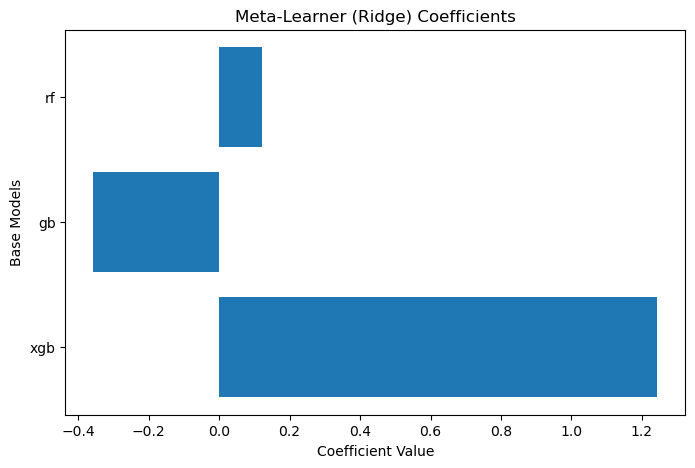

In [199]:
# The meta-learner (Ridge Regression) assigns weights to the predictions of the base models. 
# We can visualize these coefficients to understand how much each base model contributes to the final prediction.

# Extracting meta-learner coefficients from the fitted stacking model

meta_learner_coef = stacking_model.final_estimator_.coef_

# Plotting meta-learner coefficients

plt.figure(figsize=(8, 5))
plt.barh([name for name, _ in base_models], meta_learner_coef)
plt.title("Meta-Learner (Ridge) Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Base Models")
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

The stacking ensemble model, combining XGBoost, Gradient Boosting, and Random Forest as base models, utilized a Ridge Regression meta-learner to combine their predictions. After optimizing the regularization parameter alpha through GridSearchCV, the model was evaluated using K-Fold Cross-Validation and performance metrics such as MSE, RMSE, and R². The coefficients of the Ridge meta-learner indicated that XGBoost had the most significant positive impact on predictions, followed by Random Forest, while Gradient Boosting contributed negatively. The model demonstrated strong performance, with cross-validation results suggesting its robustness in predicting the target variable.

As we evaluate the performance of our model, it is clear that we have made significant progress in understanding the factors that drive used car prices. The stacking ensemble model, with its combination of XGBoost, Gradient Boosting, and Random Forest, has delivered strong results with an R-squared of 0.9321 on the test set, indicating that the model is capable of making highly accurate predictions. The model's performance on both the training and test sets, with minimal overfitting or underfitting, suggests that the features selected are capturing the key patterns in the data. This gives us confidence that the model can be used effectively to support decision-making regarding pricing strategies and inventory management. The ability to predict used car prices with a high degree of accuracy provides valuable insights into the market dynamics that can be leveraged by clients to optimize their pricing approach.

From a business standpoint, the model’s findings can directly inform pricing strategies, identifying the most influential factors in determining the value of a used car. This includes key attributes such as year, odometer and model, which our model has shown to be highly predictive of price. Given the strong performance and the meaningful insights it provides, there is no immediate need for a major revision of the model. However, it is essential to recognize that the used car market is dynamic, with trends and consumer preferences constantly evolving. To maintain the model's relevance and accuracy over time, it is advisable to periodically revisit and update the model with new data and potentially explore additional external factors such as seasonal trends or macroeconomic conditions. This ongoing process of refinement will ensure the model continues to provide valuable insights and stays aligned with the business objectives.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Objective and Approach:

This project aimed to develop a robust predictive model for estimating used car prices, providing valuable insights for car dealers to optimize their inventory and pricing strategies. The process began with data exploration and feature selection, identifying key factors that influence car prices, such as age, mileage, make, model, and more. After preprocessing the data, we applied various machine learning techniques, including Random Forest, Gradient Boosting, XGBoost, and a final stacking ensemble model to ensure accurate and reliable price predictions.

Key Findings:

The final stacking ensemble model demonstrated exceptional performance, achieving an R-squared score of 0.9321 on the test set, meaning it explains over 93% of the variance in used car prices. This strong performance highlights the model's ability to reliably predict prices based on selected features, with minimal risk of overfitting. 

The most influential drivers of used car prices were the car's age, mileage, forward wheel drive and model. Notably, cars that are not aging with lower mileage and newer models were priced higher. This suggests that dealers can leverage these key attributes to fine-tune their pricing strategy and inventory decisions.

Implications and Recommendations for Dealers:

Prioritize High-Value Attributes: Car age, Mileage, forward wheel drive and model emerged as the most critical factors influencing prices. Therefore, dealers should focus on sourcing newer cars with lower mileage that are forward wheel drive and gas powered to maximize potential sales at higher price points. Additionally, popular makes and models that align with market trends should be prioritized to ensure competitive pricing.

Dynamic Pricing Strategy: While the model provides accurate pricing estimates, it is important for dealers to continuously monitor market trends, as the used car market is influenced by various factors like supply and demand, seasonal variations, and economic conditions. Dealers should use the model's predictions as a starting point, but consider adjusting prices based on real-time market dynamics.

Refine Inventory Decisions: By aligning inventory decisions with the most influential pricing factors identified in the model, dealers can optimize their stock. For instance, cars that are likely to retain high resale value should be prioritized, helping dealers balance profitability with inventory turnover.

Next Steps

We recommend implementing a system for regularly updating the model with new data, ensuring it stays relevant and accurately reflects market trends. Additionally, incorporating external variables such as macroeconomic indicators, local demand shifts, and competitor pricing could further enhance the model’s ability to predict prices. By integrating this predictive model into their operations, dealers can gain a strategic edge, improving pricing accuracy and optimizing their inventory for greater profitability.